In [99]:
from typing import List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests

# type aliases
ArrayLike = Union[np.ndarray, List[float], List[int], float, int]

c = 2.99792458e8

In [100]:
url_tau="https://github.com/ishiishun/lst/raw/master/data/tau.csv"
url_Tsky="https://github.com/ishiishun/lst/raw/master/data/Tsky.csv"
s_tau=requests.get(url_tau).content
s_Tsky=requests.get(url_Tsky).content

In [101]:
tau_df_zenith = pd.read_csv(io.StringIO(s_tau.decode('utf-8')),
        skiprows=4,
        delim_whitespace=True,
        header=0,
        index_col=0
    )

Tsky_df_zenith = pd.read_csv(io.StringIO(s_Tsky.decode('utf-8')),
        skiprows=4,
        delim_whitespace=True,
        header=0,
        index_col=0
    )


In [102]:
Bands = {
    '3': {"f_min": 84., "f_max":116, "pwv":5.186, "Trx":40.},  #f_min (GHz), f_max(GHz), pwv(mm), Trx(K) from ALMA OT 
    '4': {"f_min":125., "f_max":163, "pwv":2.748, "Trx": 42.}, 
    '5': {"f_min":158., "f_max":211, "pwv":1.796, "Trx": 50.}, 
    '6': {"f_min":211., "f_max":275, "pwv":1.796, "Trx": 50.}, 
    '7': {"f_min":275., "f_max":373, "pwv":0.913, "Trx": 72.}, 
    '8': {"f_min":385., "f_max":500, "pwv":0.658, "Trx":135.}
    }

In [103]:
def tau_func(pwv, EL):
    tau0 = tau_df_zenith[str(pwv)]
    tau = tau0/ np.sin(EL * np.pi / 180.0)
    return tau

def Tsky_func(pwv, EL):
    tau0 = tau_df_zenith[str(pwv)]
    Tsky0 = Tsky_df_zenith[str(pwv)]
    tau = tau0/ np.sin(EL * np.pi / 180.0)
    Tsky = Tsky0 * (1. - np.exp(-tau))/(1 - np.exp(-tau0))
    return Tsky

In [104]:
def get_Tsys(band, EL = 60., eta_eff = 0.95, Tamb = 270.):
    f_min = Bands[band]["f_min"]
    f_max = Bands[band]["f_max"]
    pwv = Bands[band]["pwv"]
    Trx = Bands[band]["Trx"]
    tau = tau_func(Bands[band]["pwv"], EL)
    Tsky = Tsky_func(Bands[band]["pwv"], EL)
    eta_atm = np.exp(-tau)
    Tsys = 1./(eta_eff*eta_atm)*(Trx + eta_eff*Tsky + (1.-eta_eff)*Tamb)
    return Tsys[f_min:f_max], tau[f_min:f_max], Tsky[f_min:f_max]

In [105]:
def get_Tsys_all(band, EL = 60., eta_eff = 0.95, Tamb = 270.):
    pwvs = [0.472, 0.658, 0.913, 1.262, 1.796, 2.748, 5.186]
    df_Tsyss = pd.DataFrame()
    for pwv in pwvs:
        f_min = Bands[band]["f_min"]
        f_max = Bands[band]["f_max"]
        Trx = Bands[band]["Trx"]
        tau = tau_func(str(pwv), EL)
        Tsky = Tsky_func(str(pwv), EL)
        eta_atm = np.exp(-tau)
        Tsys = 1./(eta_eff*eta_atm)*(Trx + eta_eff*Tsky + (1.-eta_eff)*Tamb)
        df_Tsyss[str(pwv)]= Tsys
    df_ratio = pd.DataFrame()
    for column in df_Tsyss.columns:
        ratio = df_Tsyss[column]/df_Tsyss["0.472"].values
        df_ratio[column]= ratio
    return df_Tsyss, df_ratio

In [106]:
#band 3
band = "3"
EL = 60.
Tsys, tau, Tsky = get_Tsys(band, EL)
df_Tsyss, df_ratio = get_Tsys_all(band, EL)

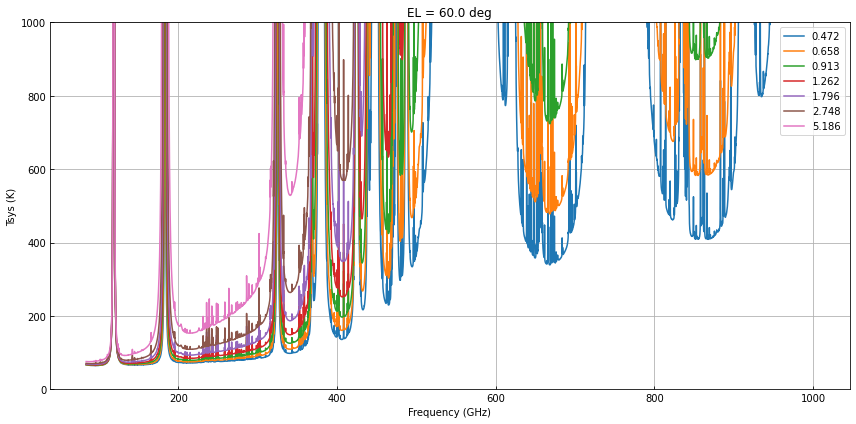

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_Tsyss.plot(ax = ax)

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"Tsys (K)")
ax.set_ylim(0, np.min([df_Tsyss["5.186"].max(), 1000.]))
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(EL),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

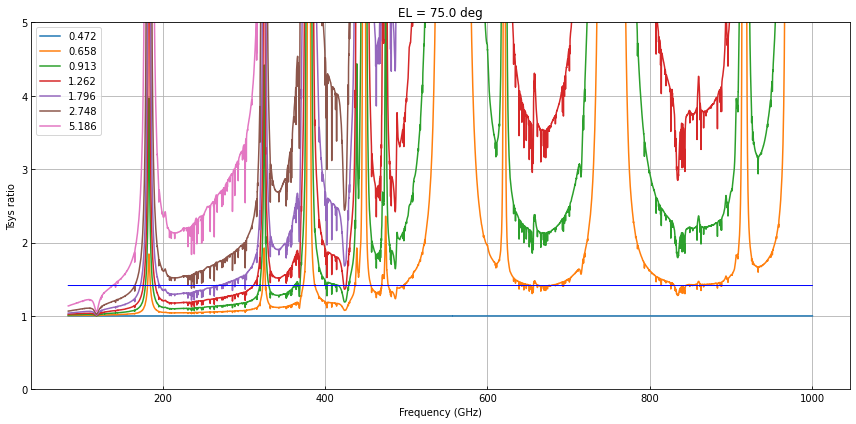

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

df_ratio.plot(ax = ax)
x = df_ratio.index
ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"Tsys ratio")
#ax.set_yscale("log")
#ax.set_xlim(Bands[band]["f_min"], Bands[band]["f_max"])
ax.set_ylim(0, 5)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(75.),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

In [109]:
df = df_ratio<np.sqrt(2)
vallist = []
vallist2 = []
vallist3 = []
for idx in df.index:
    if pd.isna(df_ratio[idx:idx]["0.472"].values) == True:
        octile = 1
        pwv = "0.472"
    elif (idx > 211. and idx < 275.): # fix the PWV for band 6 to 1.796 mm
        octile = 5
        pwv = "1.796"
    else:
        octile = np.where(df[idx:idx] == True)[1][-1]+1
        pwv = df.columns[np.where(df[idx:idx] == True)[1][-1]]
    vallist.append(octile)
    vallist2.append(pwv)
    vallist3.append(df_Tsyss[pwv][idx:idx].values[0])
df_Tsyss["octile"] = vallist
df_Tsyss["pwv"] = vallist2
df_Tsyss["Tsys"] = vallist3

In [110]:
df_Tsyss

,0.472,0.658,0.913,1.262,1.796,2.748,5.186,octile,pwv,Tsys
F,,,,,,,,,,
84.0,66.583515,6.694292e+01,6.740814e+01,6.809397e+01,6.913896e+01,7.097967e+01,7.565935e+01,7,5.186,75.659353
84.1,66.551693,6.691224e+01,6.737743e+01,6.806437e+01,6.911165e+01,7.087368e+01,7.564242e+01,7,5.186,75.642420
84.2,66.519871,6.688156e+01,6.734790e+01,6.803597e+01,6.908434e+01,7.085102e+01,7.562670e+01,7,5.186,75.626697
84.3,66.489228,6.685089e+01,6.731837e+01,6.800756e+01,6.905702e+01,7.082717e+01,7.561097e+01,7,5.186,75.610974
84.4,66.458585,6.682021e+01,6.728884e+01,6.797915e+01,6.895326e+01,7.080451e+01,7.559525e+01,7,5.186,75.595251
...,...,...,...,...,...,...,...,...,...,...
999.6,717569.809693,1.411193e+07,8.362043e+08,2.229873e+11,1.147997e+15,4.748986e+21,4.175100e+38,1,0.472,717569.809693
999.7,645168.731296,1.217222e+07,6.823932e+08,1.682319e+11,7.698807e+14,2.578192e+21,1.320357e+38,1,0.472,645168.731296
999.8,582081.928802,1.055992e+07,5.594539e+08,1.280998e+11,5.216966e+14,1.422494e+21,4.302829e+37,1,0.472,582081.928802


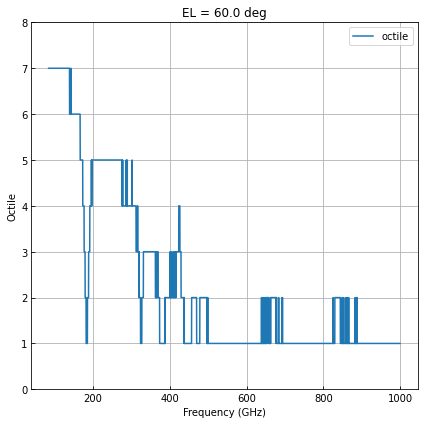

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

df_Tsyss['octile'].plot(ax = ax)
#x = df_ratio.index
#ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"Octile")
#ax.set_yscale("log")
#ax.set_xlim(Bands[band]["f_min"], Bands[band]["f_max"])
ax.set_ylim(0, 8)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(EL),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

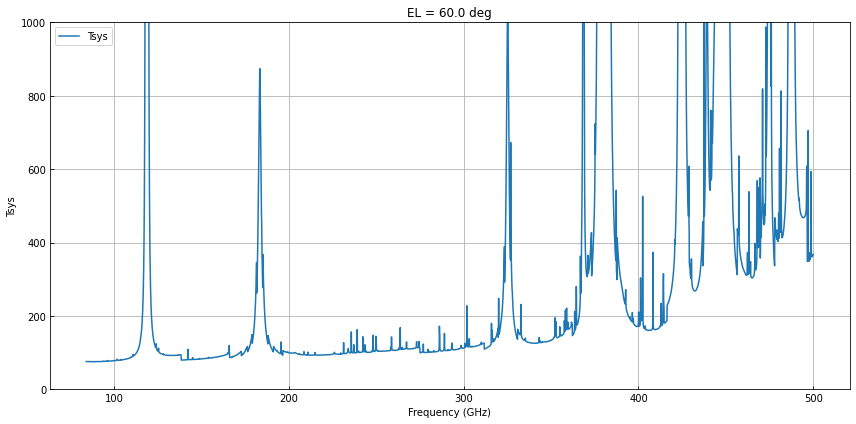

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

df_Tsyss['Tsys'][84.0:500].plot(ax = ax)
#x = df_ratio.index
#ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"Tsys")
#ax.set_yscale("log")
#ax.set_xlim(Bands[band]["f_min"], Bands[band]["f_max"])
ax.set_ylim(0, np.min([df_Tsyss["Tsys"].max(), 1000.]))
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg".format(EL),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

In [113]:
def LST_HPBW(F: ArrayLike, D = 50) -> ArrayLike:
    c = 2.99792458e8
    wavelength =  c/F
    return 1.21 * wavelength/D
    

In [114]:
def PlotHPBW():
    """Plot half power beam width of DESHIMA 2.0 on ASTE.

    Returns
    -------
    html
        HTML object for download link (to be used in Jupyter notebook).

    """
    F = np.arange(84., 500.1, 0.1)*1e9

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(
        F / 1e9,
        LST_HPBW(F) * 180 * 60 * 60 / np.pi,
        linewidth=1,
        color="b",
        alpha=1,
        label="HPBW",
    )

    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("HPBW (arcsec)")
    ax.set_yscale("linear")
    ax.set_xlim(84, 500)
    ax.set_ylim(0, 20)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()

    # Create download link
    df_download = pd.DataFrame(data=F, columns=["F"])
    df_download["HPBW"] = LST_HPBW(F) * 180 * 60 * 60 / np.pi

    return



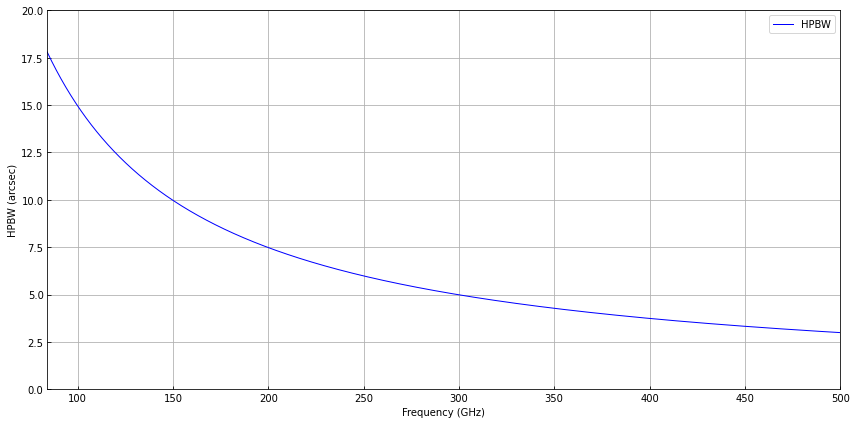

In [115]:
PlotHPBW()

In [116]:
def get_dTa(F,                      # frequency, in Hz
            HPBW,                   # HPBW, in arcsec.          
            df_Tsyss,               # Tsys dataframe
            sample_length = 1./5,   # length of the scan per a sample of integration, in HPBW 
            cell_size = 1./9,       # cell size, in HPBW
            sep_scan = 1./3,        # separation of raster scans, in HPBW
            t_dump = 0.1,          # in sec.
            t_sub_on = 20,          # in sec.
            N_scan = 2,             # number of the raster scans per an OFF scan
            d_OFF = 60.,            # separation between ON and OFF, in arcmin., assuming a 1-deg separation
            dV = 0.3,               # velocity resolution in km/s  
            N_beam = 100.,           # number of beams
            dTa_des = 0.3           # desired sensitivity in K
           ):
    F = F/1e9
    v = HPBW*sample_length/t_dump   # scan velociy 
    cell = HPBW*cell_size           # cell size (Brogan & Hunter 2014)
    sep_scan = HPBW*sep_scan  
    w_x = v*t_sub_on
    w_y = w_x
    area = w_x*w_y/3600./3600.      # in deg^2
    N_row = np.ceil(w_y/sep_scan)
    t_os = t_sub_on*N_row
    t_tran = 7.
    t_app = 6.
    t_tran_OFF = np.ceil(4.4*d_OFF**(0.26)) 
    t_OH = 2*t_tran_OFF/N_scan + t_app + t_tran*(N_scan-1)/N_scan
    f_cal = 16./15. # R-Sky every 15 min.
    eta = 10.2
    t_sub_off = np.sqrt((t_sub_on + t_OH)* eta*cell*t_sub_on/w_x)*np.sqrt(N_scan)
    t_cell_on = eta*t_sub_on*cell*cell/(w_x*sep_scan)*N_beam
    t_cell_off = t_sub_off*cell/sep_scan*N_beam
    dfreq = F*dV/(c/1.e3)*1.e9
    dTa = df_Tsyss['Tsys'][F[0]:F[-1]].values*np.sqrt(1/t_cell_on + 1/t_cell_off)/np.sqrt(dfreq)
    Tsys_factor_nro = 1.1*np.exp(-0.18*(1/np.sin(70./180*np.pi)-1/np.sin(EL/180*np.pi)))
    dTa_nro = Tsys_factor_nro*dTa/0.88 #devided by the efficiency of the spectrometer
    t_total = N_row*(t_sub_on + t_OH + t_sub_off/N_scan)*f_cal
    df_dTa = pd.DataFrame(index = F)
    df_dTa.index.name = "F"
    df_dTa["dTa"] = dTa
    df_dTa["t_total"] = t_total/60./60.
    df_dTa["map_size"] = w_x
    df_dTa["area"] = area
    t_total_for_dTa_des_1deg2 = (t_total/60./60.)*np.power(dTa/dTa_des, 2.)/area
    df_dTa["t_total_dTa_des_1deg2"] = t_total_for_dTa_des_1deg2
    return df_dTa, N_beam, t_dump, dTa_des

In [117]:
F = np.linspace(84., 500., num = int((500.1-84.)/0.1), endpoint = True)*1e9
HPBW = LST_HPBW(F, D=45.) * 180 * 60 * 60 / np.pi

df_dTa, N_beam, t_dump, dTa_des = get_dTa(F, HPBW, df_Tsyss) 

In [118]:
df_dTa

,dTa,t_total,map_size,area,t_total_dTa_des_1deg2
F,,,,,
84.0,0.062447,1.634493,791.770648,0.048372,1.464105
84.1,0.062396,1.634493,790.829185,0.048257,1.465192
84.2,0.062346,1.634493,789.889958,0.048142,1.466325
84.3,0.062296,1.648114,788.952959,0.048028,1.479685
84.4,0.062246,1.634493,788.018181,0.047915,1.468586
...,...,...,...,...,...
499.6,0.122792,1.634493,133.123968,0.001367,200.248825
499.7,0.123187,1.634493,133.097327,0.001367,201.619821
499.8,0.123462,1.648114,133.070697,0.001366,204.292099


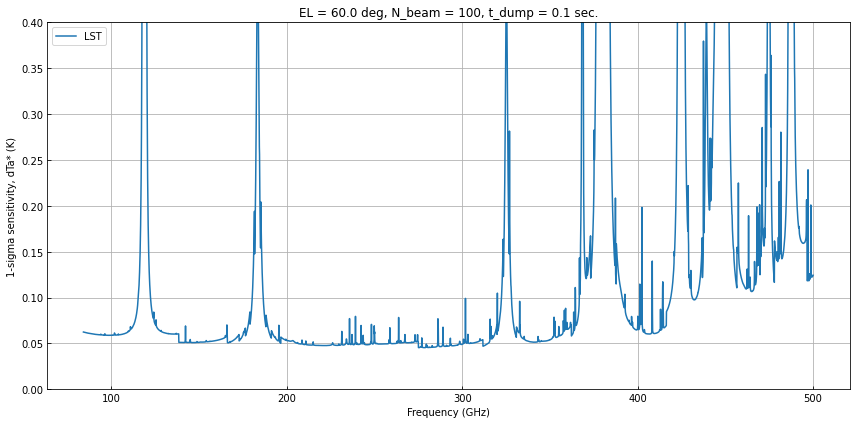

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(df_dTa.index, df_dTa["dTa"], label = "LST")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("1-sigma sensitivity, dTa* (K)")
ax.set_ylim(0, 0.4)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg, N_beam = {}, t_dump = {} sec.".format(EL, int(N_beam), t_dump),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

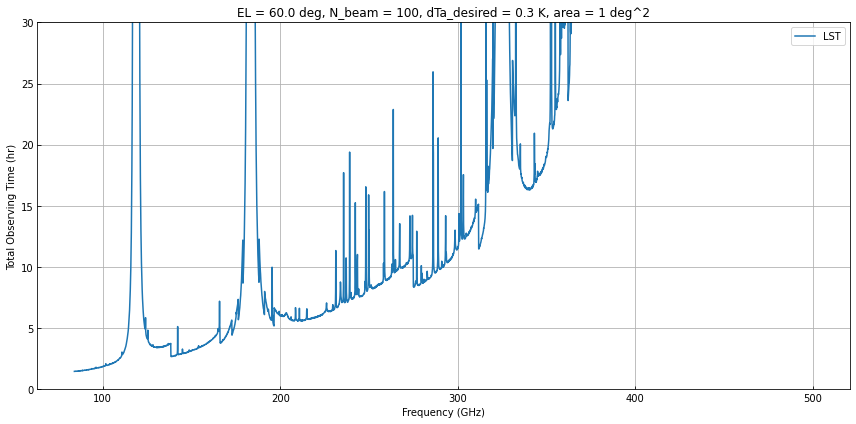

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2"], label = "LST")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Total Observing Time (hr)")
ax.set_ylim(0, 30)
ax.tick_params(direction="in", which="both")
ax.grid(True)
ax.set_title(
    "EL = {} deg, N_beam = {}, dTa_desired = {} K, area = {} deg^2".format(EL, int(N_beam), dTa_des, 1),
    fontsize=12,
)
ax.legend()
fig.tight_layout()

In [121]:
# examples for specific emission lines

print("*Survey Speed: 100 beams, 1 deg^2, dTa* = 0.3 K, dV = 0.3 km/s\n")
# time for CO(3-2) at 345.8 GHz
f = 345.796
t_obs = df_dTa["t_total_dTa_des_1deg2"][np.round(f, decimals=1)]
print("- CO(3-2) at {0:} GHz: t_obs = {1:.2f} hr".format(f, t_obs))

# time for 13CO(1-0) at 110.2 GHz
f = 110.201
t_obs = df_dTa["t_total_dTa_des_1deg2"][np.round(f, decimals=1)]
print("- 13CO(1-0) at {0:} GHz: t_obs = {1:.2f} hr".format(f, t_obs))


*Survey Speed: 100 beams, 1 deg^2, dTa* = 0.3 K, dV = 0.3 km/s

- CO(3-2) at 345.796 GHz: t_obs = 17.55 hr
- 13CO(1-0) at 110.201 GHz: t_obs = 2.62 hr
